## Map Function

Map applies a function to all the items in an input list. (CPU concurrency?)

In [ ]:
items = [1, 2, 3, 4, 5]
squared = []
for i in items:
  squared.append(i**2)

print(squared)

In [ ]:
# using map parallelism
squared = list(map(lambda x: x**2, items))
print(squared)

## Filter Function

Filter creates a list of elements for which a function returns true.

In [ ]:
# using filter parallelism
numbers = range(-5, 5)
less_than_zero = list(filter(lambda x: x <0, numbers))
print(less_than_zero)

## Reduce Function

In [ ]:
from functools import reduce

# Multiply all numbers in a list
data = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29]
multiplier = lambda x, y: x*y
reduce(multiplier, data)

The same code using a for loop.

In [ ]:
product = 1 
for x in data:
  product = product * x

product

##MapReduce


In [ ]:
import math

def area(r):
  """ area of a circle with radius r."""
  return math.pi * (r**2)

radii = [2, 5, 7.1, 0.3, 10]

# Method 1: direct method
areas = []
for r in radii:
  a = area(r)
  areas.append(a)
print(areas)

# Method 2: Use 'map' function
print(list(map(area, radii)))

## Multiprocessing

Python’s built-in multiprocessing library allows programmers to run multiple processes in parallel if the operating system and hardware support it.

One of the simplest ways to use the multiprocessing library is to create a pool of processes and to instruct all the processes in that pool execute the same function.

In [ ]:
def double(x):
  return x + x

# multi processing
import multiprocessing as mp

with mp.Pool(processes = mp.cpu_count()) as pool:
  ys = pool.map(double, [1, 2, 3, 4])
  print(ys)


## An Example

A popular use case used in introductory materials on frameworks that support the MapReduce paradigm is that of empirically estimating the value of 𝜋. The formula for the area A of a circle having radius r is A = 𝜋r², so the radius and area of a circle can be used to compute 𝜋 = A / r². Letting r = 1/2 yields 𝜋 = A / (1/2)² = 4A. So to estimate 𝜋, it is sufficient to multiply by 4 the area of a circle having radius 1/2.

A circle with a radius of 1/2 has a diameter of 1 and so it fits perfectly inside a square having sides of length 1 (and, thus, an area of 1 ⋅ 1 = 1). This makes it possible to estimate A by generating random points inside a square of area 1 and then counting how many of these random points are actually inside the circle of radius 1/2 that is inscribed perfectly inside that square.

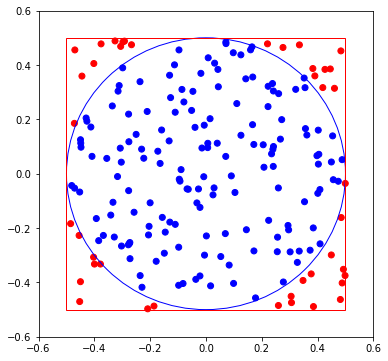

One approach that can make a MapReduce-like workflow concise to implement is to ensure that the representation of a data entry and a partially aggregated set of entries is always the same. This makes it possible to have just a single function that can always take two partial results and combine it into a new, larger partial result. In this example, the representation reflects the final goal: a count of points that are in the circle and a count of all the points in the square (both inside and outside of the circle) that have been generated so far.

The initial data entries are now just a special case of the above: a point inside the circle is represented as `{"circle":1, "square":1}` and a point outside the circle is represented as `{"circle":0, "square":1}`. You can now implement the function trial below that corresponds to the map step of the MapReduce-like workflow.

In [ ]:
from random import random

def trial(instance):
    x = -0.5 + random()
    y = -0.5 + random() 
    if (x**2 + y**2 <= 0.5**2):
      return {"circle":1, "square": 1}
    else:
      return {"circle":0, "square": 1}

The function combine for the second step is now even simpler to implement. All you need is a function that combines two aggregated estimates into a new aggregated estimate.

In [ ]:
def combine(estimate_a, estimate_b):
    return {
        "circle": estimate_a["circle"] + estimate_b["circle"], 
        "square": estimate_a["square"] + estimate_b["square"]
    }

Using the `trial` and `combine` functions to implement a MapReduce-like workflow is then straightforward.

In [ ]:
from functools import reduce
estimate = reduce(combine, map(trial, range(4000)))
print(estimate) # E.g., {'circle': 3153, 'square': 4000}.
print(4 * (estimate["circle"] / estimate["square"])) # E.g., 3.146.

The mr4mp library provides a thin wrapper API around the multiprocessing library to enable even more concise implementations of MapReduce-like workflows. Assuming the trial and combine functions have already been defined, the entire workflow can be implemented using just the few lines of code shown below.

In [ ]:
!pip install mr4mp
!pip install parts

In [ ]:
from functools import partial, reduce
from parts import parts
with mp.Pool(processes = mp.cpu_count()) as pool:
    es_per_process = pool.map(
        partial(map, trial),
        parts(range(10000), pool._processes)
    )
    e = reduce(
        combine,
        pool.map(partial(reduce, combine), es_per_process)
    )
    print(4*(e["circle"] / e["square"])) # Outputs, e.g., 3.1452.

In [ ]:
import mr4mp
e = mr4mp.pool().mapreduce(trial, combine, range(1000))  ## the bigger the range is, the more accurate the estimation is. 
print(4 * (e["circle"] / e["square"])) # Outputs, e.g., 3.1528.